<a href="https://colab.research.google.com/github/yandri918/opencv-bootcamp/blob/main/03_Keras_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Learn How to use Keras for Modeling Linear Regression</h1>

Before studying deep neural networks, we will cover the fundamental components of a simple (linear) neural network. We'll begin with the topic of linear regression. Since linear regression can be modeled as a neural network, it provides an excellent example to introduce the essential components of neural networks. Regression is a form of supervised learning which aims to model the relationship between one or more input variables (features) and a continuous (target) variable. We assume that the relationship between the input variables $x$ and the target variable $y$ can be expressed as a weighted sum of the inputs (i.e., the model is linear in the parameters). In short, linear regression aims to learn a function that maps one or more input features to a single numerical target value.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/keras-linear-regression-model-plot.png' width=1000 align='center'><br/>



## Table of Contents
* [1 Dataset Exploration](#1-Dataset-Exploration)
* [2 Linear Regression Model](#2-Linear-Regression-Model)
* [3 Neural Network Perspective and Terminology](#3-Neural-Network-Perspective-and-Terminology)
* [4 Modeling a Neural Network in Keras](#4-Modeling-a-Neural-Network-in-Keras)
* [5 Conclusion](#5-Conclusion)

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import layers

import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1 Dataset Exploration

## 1.1 Load the Boston Housing Dataset
In this notebook, we will be working with the Boston Housing dataset. This dataset contains information collected by the U.S Census Service concerning housing in Boston MA. It has been used extensively throughout the literature to benchmark algorithms and is also suitable for demonstration purposes due to its small size. The dataset contains 14 unique attributes, among which is the median value (price in $K) of a home for a given suburb. We will use this dataset as an example of how to develop a model that allows us to predict the median price of a home based on a single attribute in the dataset (average number of rooms in a house).  

Keras provides the `load_data()` function to load this dataset. Datasets are typically partitioned into `train`, and `test` components, and the `load_data()` function returns a tuple for each. Each tuple contains a 2-dimensional array of features (e.g., X_train) and a vector that contains the associated target values for each sample in the dataset (e.g., y_train). So, for example, the rows in `X_train` represent the various samples in the dataset and the columns represent the various features. In this notebook, we are only going to make use of the training data to demonstrate how to train a model. However, in practice, it is very important to use the test data to see how well the trained model performs on unseen data.

In [3]:
# Load the Boston housing dataset.
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

print(X_train.shape)
print("\n")
print("Input features: ", X_train[0])
print("\n")
print("Output target: ", y_train[0])

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(404, 13)


Input features:  [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


Output target:  15.2


## 1.2 Extract Features from the Dataset

In this notebook we are only going to use a single feature from the dataset, so to keep things simple, we will store the feature data in a new variable.

In [4]:
boston_features = {
    "Average Number of Rooms": 5,
}

X_train_1d = X_train[:, boston_features["Average Number of Rooms"]]
print(X_train_1d.shape)

X_test_1d = X_test[:, boston_features["Average Number of Rooms"]]

(404,)


## 1.3 Plot the Features
Here we plot the median price of a home vs. the single feature ('Average Number of Rooms').

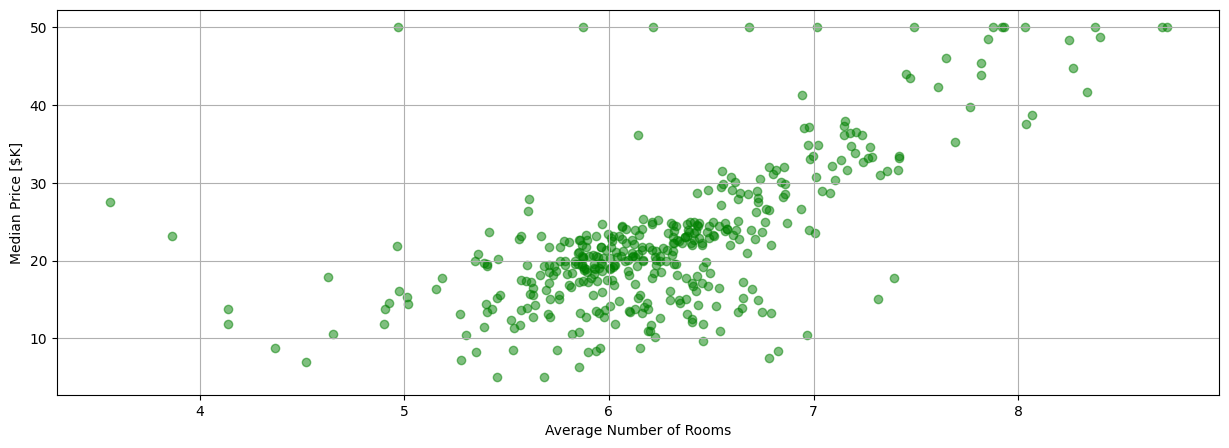

In [5]:
plt.figure(figsize=(15, 5))

plt.xlabel("Average Number of Rooms")
plt.ylabel("Median Price [$K]")
plt.grid("on")
plt.scatter(X_train_1d[:], y_train, color="green", alpha=0.5)

## 2 Linear Regression Model

Let's first start with a clear picture of what we are trying to accomplish. The plot below shows the training data for the single independent variable (number of rooms) and the dependent variable (the median price of a house). We would like to use linear regression to develop a reliable model for this data. In this example, the model is simply a straight line defined by its slope ($m$) and y-intercept ($b$).

<img src='https://learnopencv.com/wp-content/uploads/2023/01/keras-linear-regression-model-plot.png' width=1000 align='center'><br/>



## 3 Neural Network Perspective and Terminology

The figure below shows how this model can be represented as a simple (single neuron) network. We will use this simple example to introduce neural network components and terminology. The input data ($x$) consists of a single feature (average number of rooms), and the predicted output ($y'$) is a scalar (predicted median price of a home). Note that each data sample in the dataset represents the statistics for a Boston suburb. The model parameters ($m$ and $b$), are learned iteratively during the training process. As you may already know, the model parameters can be computed by the method of Ordinary Least Squares (OSL) in the closed form. However, we can also solve this problem iteratively using a numerical technique called **Gradient Descent**, which is the basis for how neural networks are trained. We will not cover the details of gradient descent in this notebook, but it's important to understand that it's an iterative technique that is used to tune the parameters of the model.

 <img src='https://learnopencv.com/wp-content/uploads/2023/01/keras-linear-regression-forward-pass-block-diagram.png' width=700 align='center'><br/>

The network contains just a single neuron that takes a single input ($x$) and produces a single output ($y'$) which is the predicted (average) price of a home. The single neuron has two trainable parameters, which are the slope ($m$) and y-intercept ($b$) of the linear model. These parameters are more generally known as the weight and bias, respectively. In regression problems, it is common for the model to have multiple input features, where each input has an associated weight ($w_i$), but in this example, we will use just a single input feature to predict the output. So, in general, a neuron typically has multiple weights ($w_1$, $w_2$, $w_3$, etc.) and a single bias term ($b$). In this example, you can think of the neuron as the mathematical computation of $mx + b$, which produces the predicted value $y'$.

A slightly more formal diagram is shown below for the same model. Here we have now introduced the concept of a **feedback loop** that shows how model parameters ($w$ and $b$) are updated during the training process. Initially, the model parameters are initialized to small random values. During the training process, as training data is passed through the network, the predicted value of the model ($y'$) is compared to the ground truth ($y$) for a given sample from the dataset. The difference is used as the basis to compute a **loss** which is then used as feedback in the network to adjust the model parameters in a way that improves the prediction. This process involves two steps called **Gradient Descent** and **Backpropagation**. It's not important at this stage to understand the mathematical details of how this works, but it is important to understand that there is an iterative process to training the model.

 <img src='https://learnopencv.com/wp-content/uploads/2023/01/keras-linear-regression-weight-update-block-diagram.png' width=700 align='center'><br/>


The **Loss Function** we use can take many forms. For this example, we will use **Mean Squared Error (MSE)** which is a very common loss function used in regression problems.

$$ J = \frac{1}{m}\sum_{i=1}^{m} (y_{i}' - y_{i})^2 $$

The basic idea is that we want to minimize the value of this function which is a representation of the error between our model and the training dataset. In the equation above, $m$ is the number of training samples.

## 4 Modeling a Neural Network in Keras
The network diagram in the previous section represents the simplest possible neural network. The network has a single layer consisting of a single neuron that outputs $wx+b$. For every training sample, the predicted output $y'$ is compared to the actual value from the training data, and the loss is computed. The loss can then be used to fine-tune (update) the model parameters.

All of the details associated with training a neural network are taken care of by Keras as summarized in the following workflow:

1. Build/Define a network model using predefined layers in Keras.
2. Compile the model with `model.compile()`
3. Train the model with `model.fit()`
4. Predict the output `model.predict()`


### 4.1 Define the Keras Model

In [6]:
model = Sequential()

# Define the model consisting of a single neuron.
model.add(Dense(units=1, input_shape=(1,)))

# Display a summary of the model architecture.
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

### 4.2 Compile the Model

In [7]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005), loss="mse")

### 4.3 Train the Model

In [8]:
history = model.fit(
    X_train_1d,
    y_train,
    batch_size=16,
    epochs=101,
    validation_split=0.3,
)

Epoch 1/101
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 457.5674 - val_loss: 565.0852
Epoch 2/101
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 425.6486 - val_loss: 536.2750
Epoch 3/101
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 401.0424 - val_loss: 509.2116
Epoch 4/101
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 377.7821 - val_loss: 483.1200
Epoch 5/101
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 355.4173 - val_loss: 457.8921
Epoch 6/101
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 333.8839 - val_loss: 433.5110
Epoch 7/101
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 313.1714 - val_loss: 409.9739
Epoch 8/101
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 293.2773 - val_loss: 387.2798
Epoch 9/101
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 274.2003 - val_loss: 365.4276
Epoch 10/101
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 255.9389 - val_loss: 344.4164
Epoch 11/101
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 238.4916 - val_loss: 324.2455
Epoch 12/101
18/18

### 4.4 Plot the Training Results

In [9]:
def plot_loss(history):
    plt.figure(figsize=(20,5))
    plt.plot(history.history['loss'], 'g', label='Training Loss')
    plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
    plt.xlim([0, 100])
    plt.ylim([0, 300])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

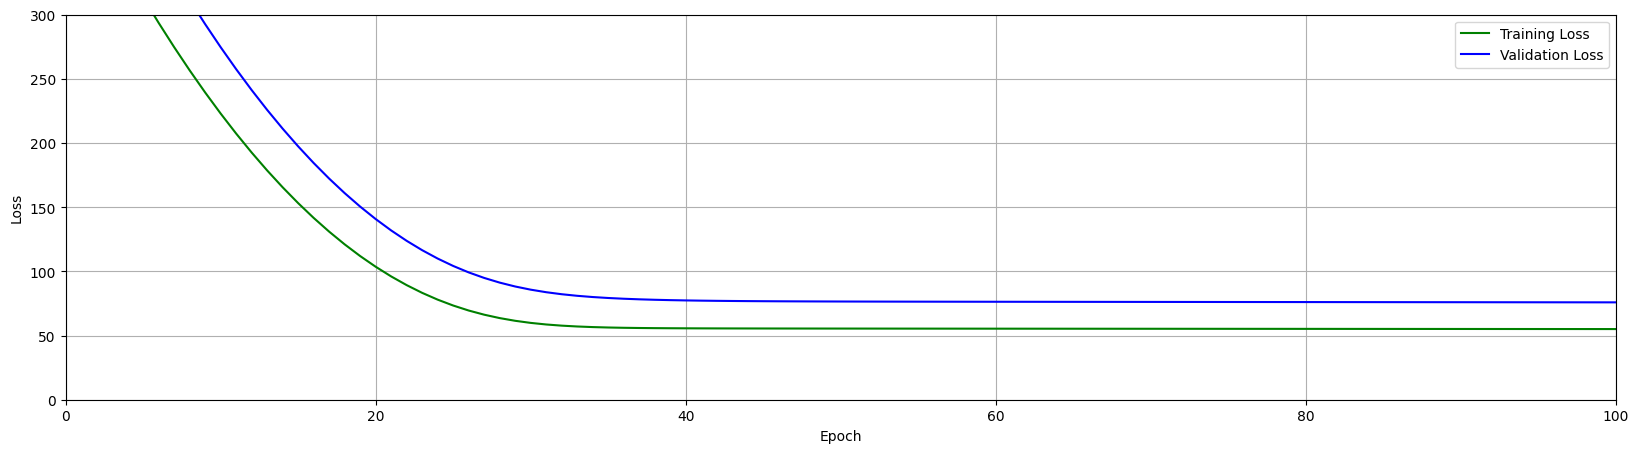

In [ ]:
plot_loss(history)

The loss curves above are fairly typical. First, notice that there are two curves, one for the training loss and one for the validation loss. Both are large initially and then steadily decrease and eventually level off with no further improvement after about 30 epochs. Since the model is only trained on the training data, it is also fairly typical that the training loss is lower than the validation loss.

### 4.4 Make Predictions using the Model

We can now use the `predict()` method in Keras to make a single prediction. In this example, we pass a list of values to the model (representing the average number of rooms), and the model returns the predicted value for the price of a home for each input.

In [10]:
# Predict the median price of a home with [3, 4, 5, 6, 7] rooms.
x = np.array([3, 4, 5, 6, 7])
y_pred = model.predict(x)
for idx in range(len(x)):
    predicted_price = y_pred[idx].item()
    print(f"Predicted price of a home with {x[idx]} rooms: ${int(predicted_price * 10) / 10}K")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted price of a home with 3 rooms: $11.8K
Predicted price of a home with 4 rooms: $15.0K
Predicted price of a home with 5 rooms: $18.2K
Predicted price of a home with 6 rooms: $21.3K
Predicted price of a home with 7 rooms: $24.5K


### 4.5 Plot the Model and the Data

In [11]:
# Generate feature data that spans the range of interest for the independent variable.
x = np.linspace(3, 9, 10)

# Use the model to predict the dependent variable.
y = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [12]:
def plot_data(x_data, y_data, x, y, title=None):

    plt.figure(figsize=(15,5))
    plt.scatter(x_data, y_data, label='Ground Truth', color='green', alpha=0.5)
    plt.plot(x, y, color='k', label='Model Predictions')
    plt.xlim([3,9])
    plt.ylim([0,60])
    plt.xlabel('Average Number of Rooms')
    plt.ylabel('Price [$K]')
    plt.title(title)
    plt.grid(True)
    plt.legend()

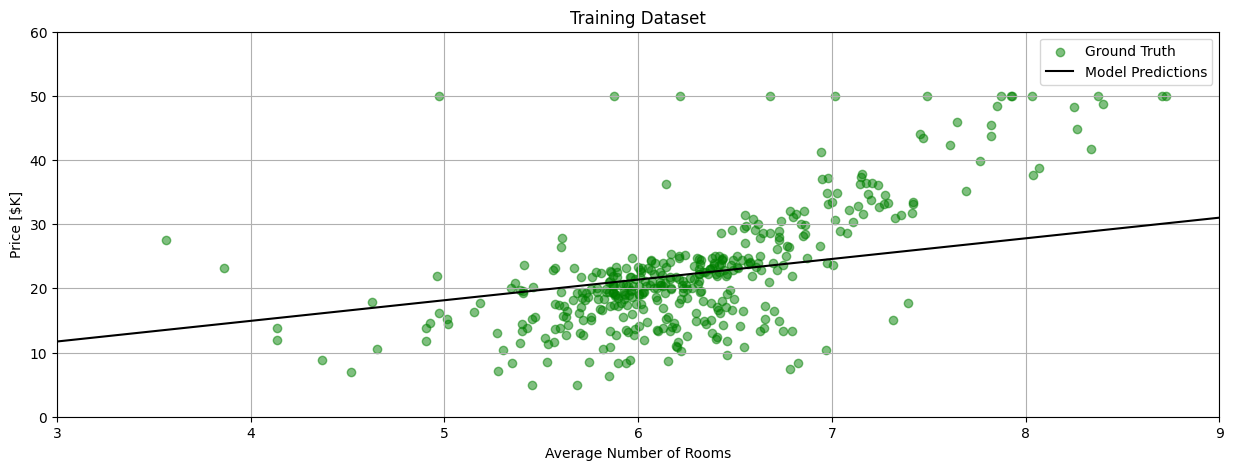

In [ ]:
plot_data(X_train_1d, y_train, x, y, title='Training Dataset')

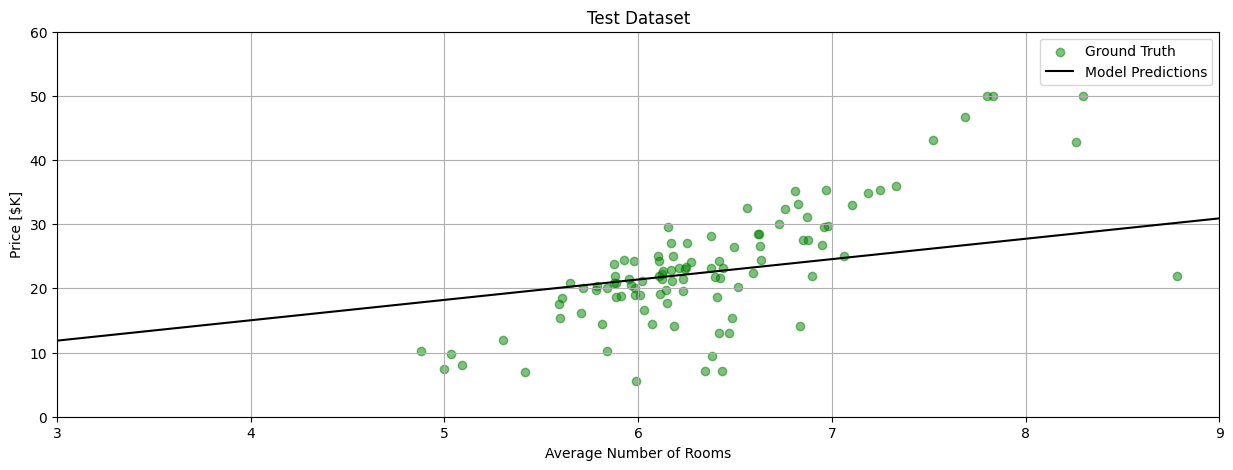

In [13]:
plot_data(X_test_1d, y_test, x, y, title='Test Dataset')

## 5 Conclusion

In this notebok, we introduced the topic of linear regression in the context of a simple neural network. We showed how Keras can be used to model and train the network to learn the parameters of the linear model and how to visualize the model predictions.